<a href="https://colab.research.google.com/github/Aleksiiej/Machine-Learning/blob/main/Network_traffic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Zadanie 4

# 4.2.1.1

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve,
                             roc_auc_score)
from tensorflow.keras.callbacks import EarlyStopping
from keras.saving import load_model

columns = []
with open('kddcup.names') as f:
  for line in f:
    if ':' in line:
      columns.append(line.split(':')[0])
columns.append('outcome')

df = pd.read_csv('kddcup.data_10_percent.gz')
df.columns = columns
print(df.info())
print(df['outcome'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  num_compromised              494020 non-null  int64  
 13 

In [ ]:
# Column 'src_bytes' takes to much place in RAM to be plotted
columns.remove('src_bytes')
columns.remove('outcome')

            duration     src_bytes     dst_bytes           land  \
count  494020.000000  4.940200e+05  4.940200e+05  494020.000000   
mean       47.979400  3.025616e+03  8.685232e+02       0.000045   
std       707.747185  9.882191e+05  3.304003e+04       0.006673   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000000  4.500000e+01  0.000000e+00       0.000000   
50%         0.000000  5.200000e+02  0.000000e+00       0.000000   
75%         0.000000  1.032000e+03  0.000000e+00       0.000000   
max     58329.000000  6.933756e+08  5.155468e+06       1.000000   

       wrong_fragment         urgent            hot  num_failed_logins  \
count   494020.000000  494020.000000  494020.000000      494020.000000   
mean         0.006433       0.000014       0.034519           0.000152   
std          0.134805       0.005510       0.782103           0.015520   
min          0.000000       0.000000       0.000000           0.000000   
25%          0.000000     

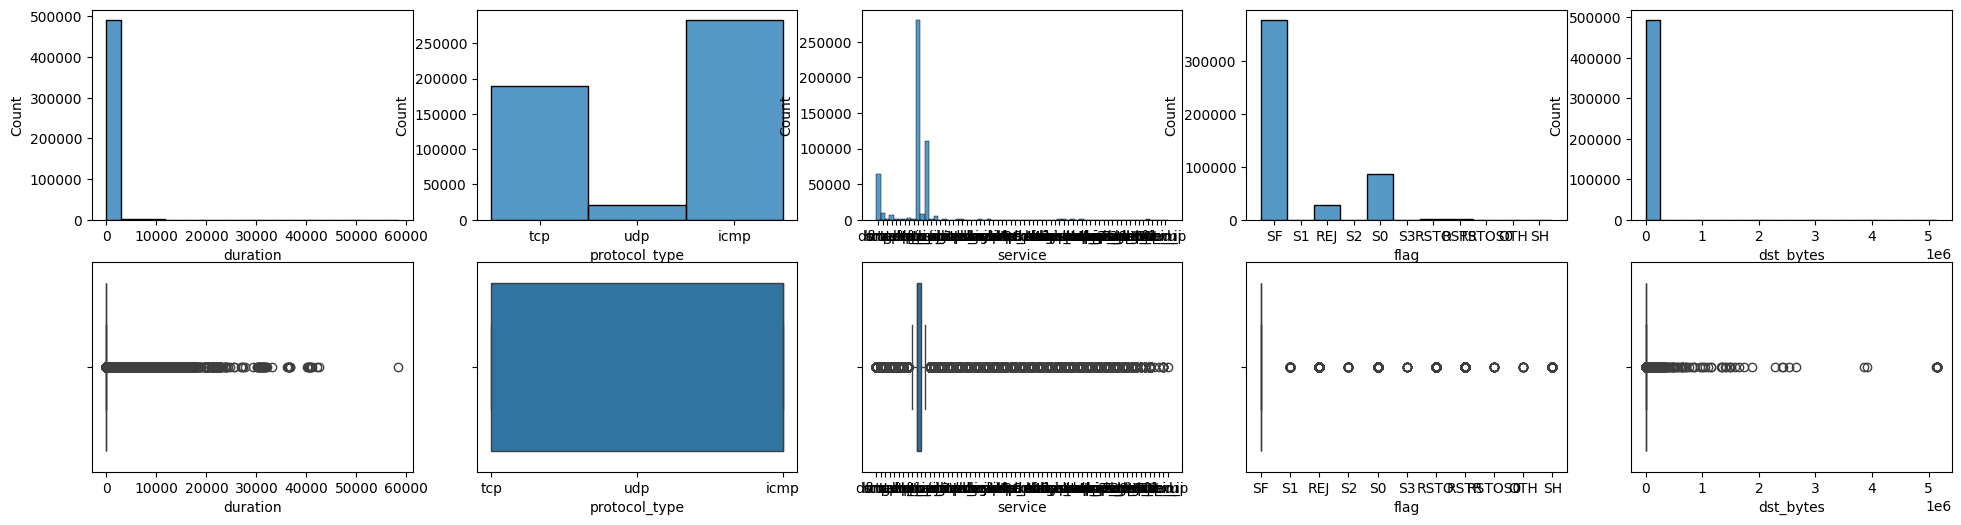

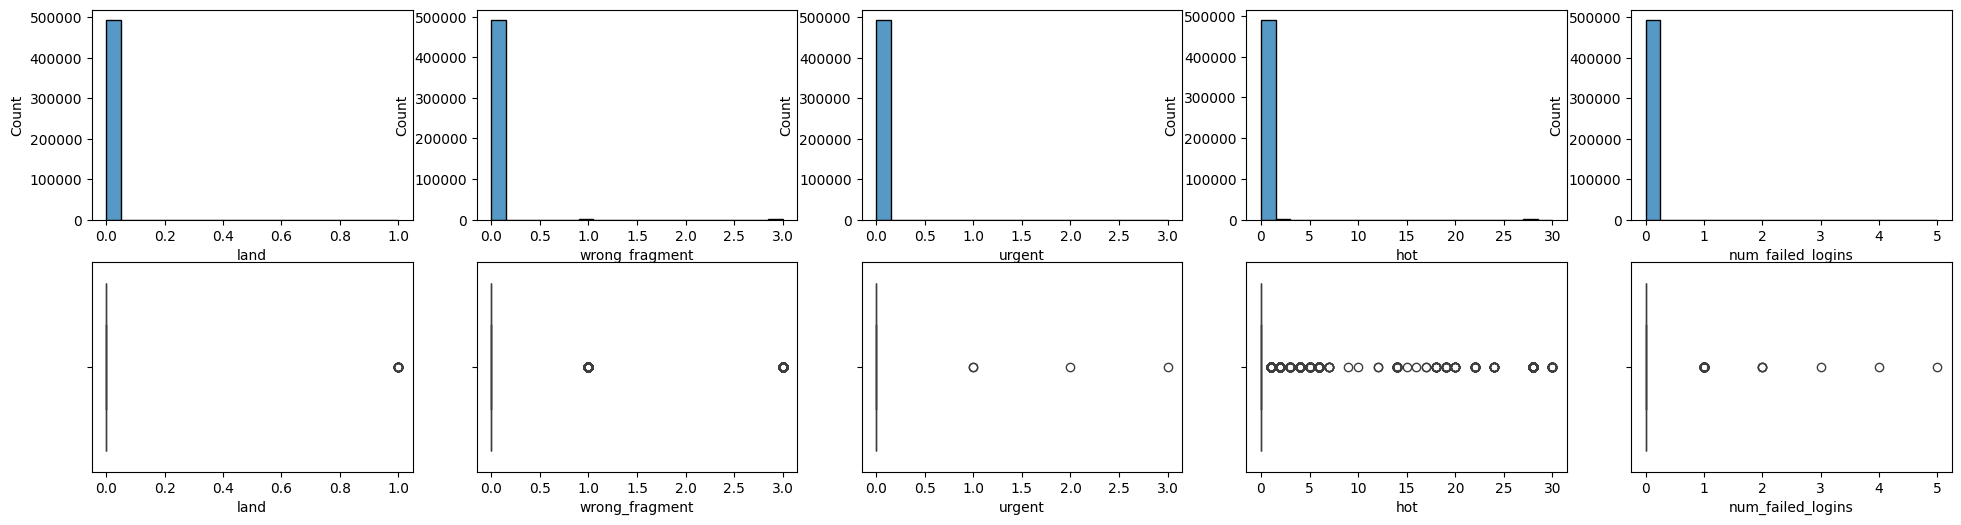

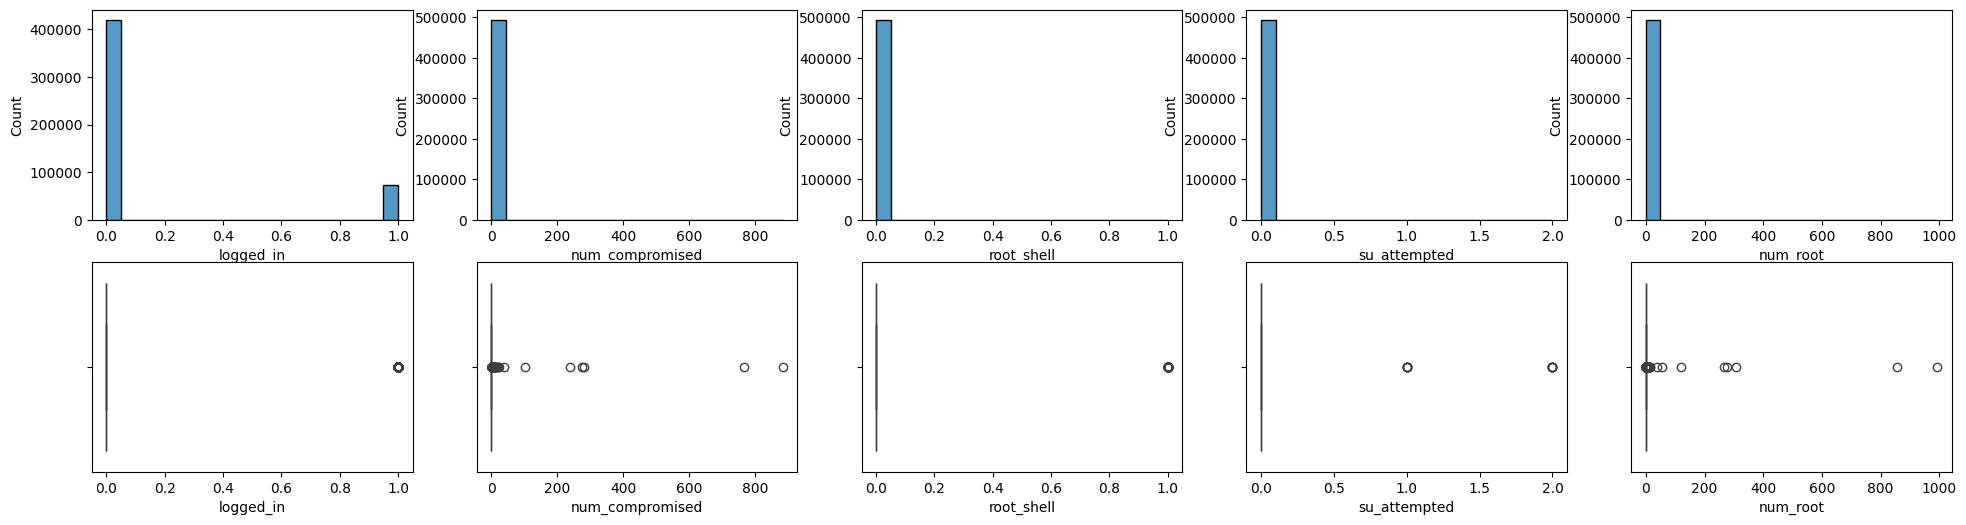

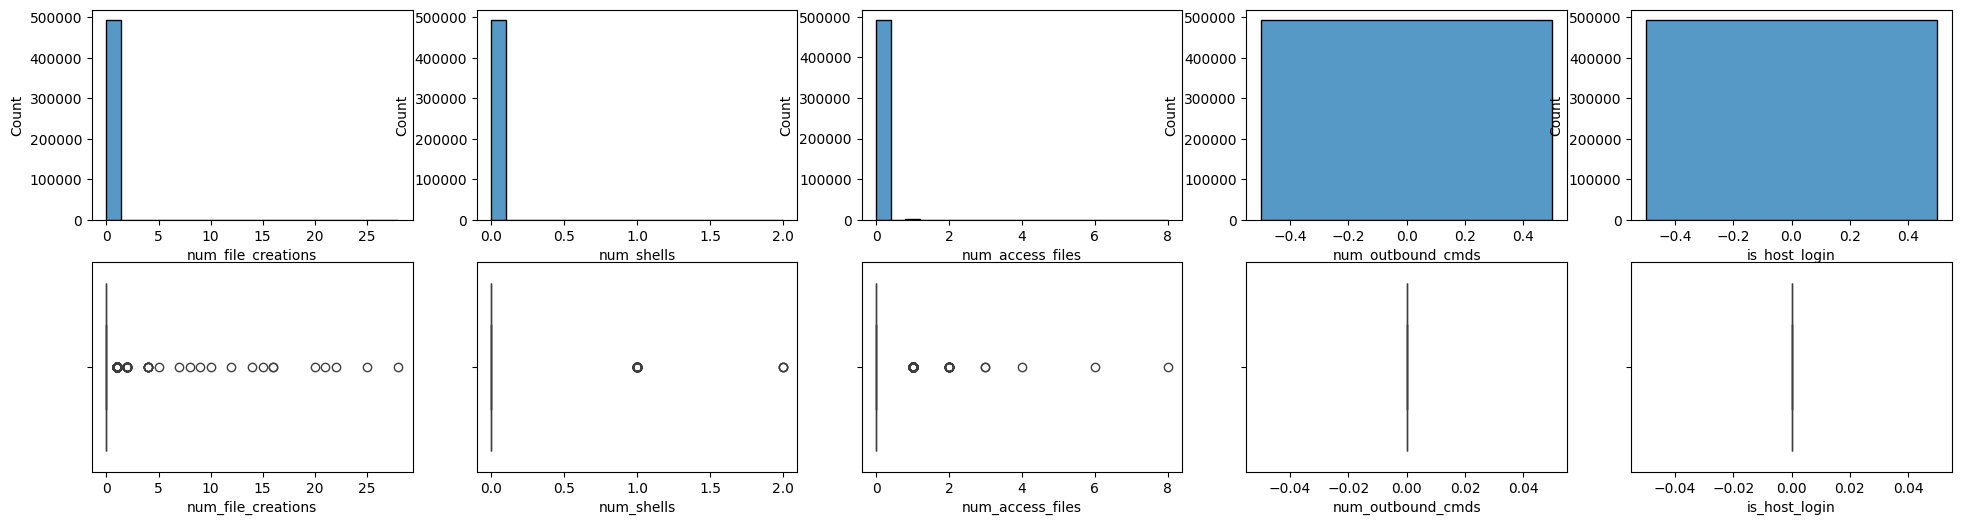

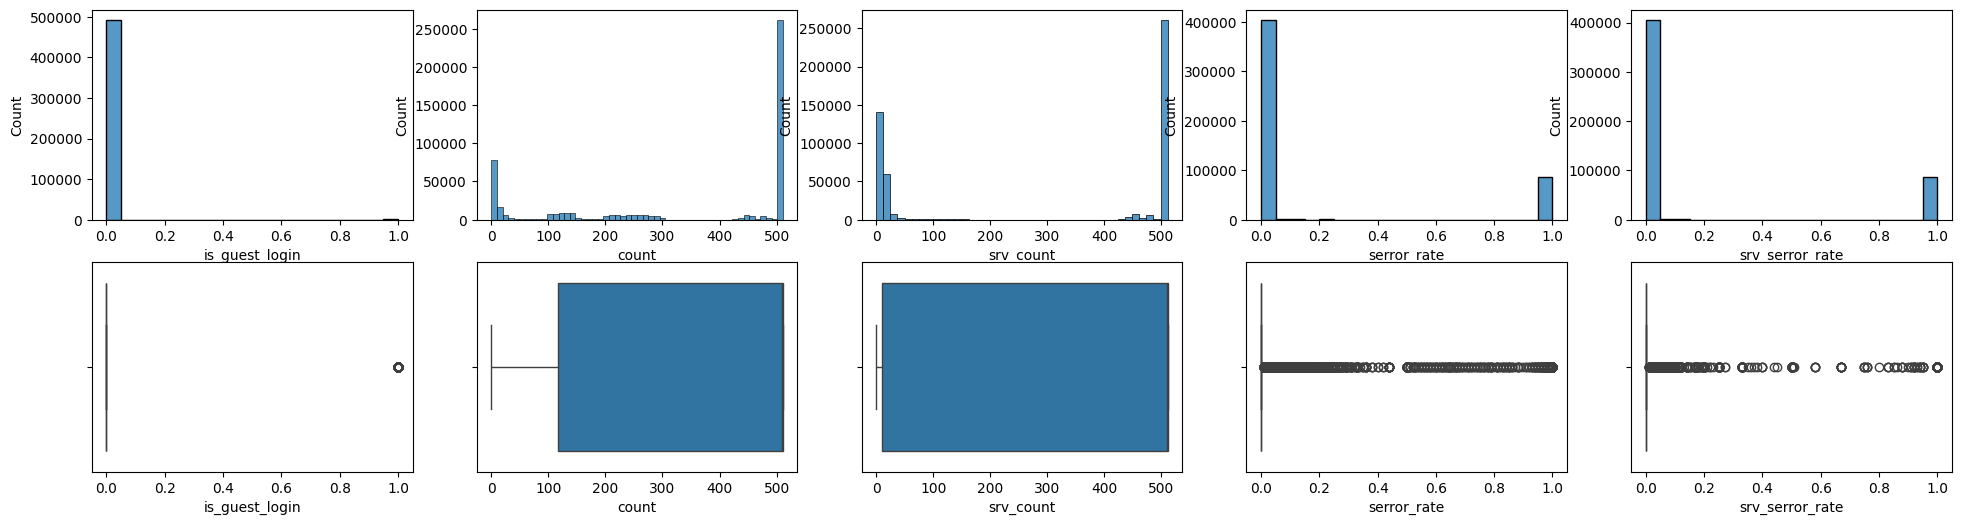

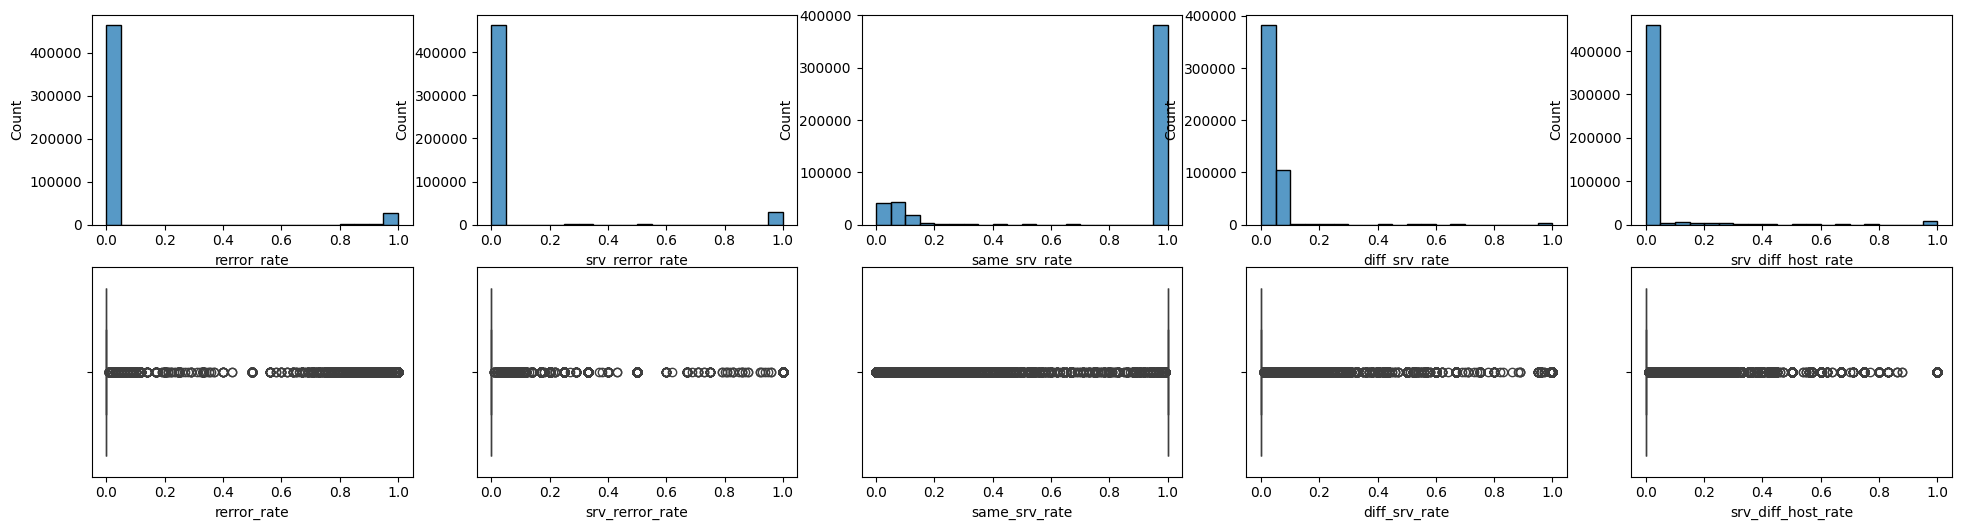

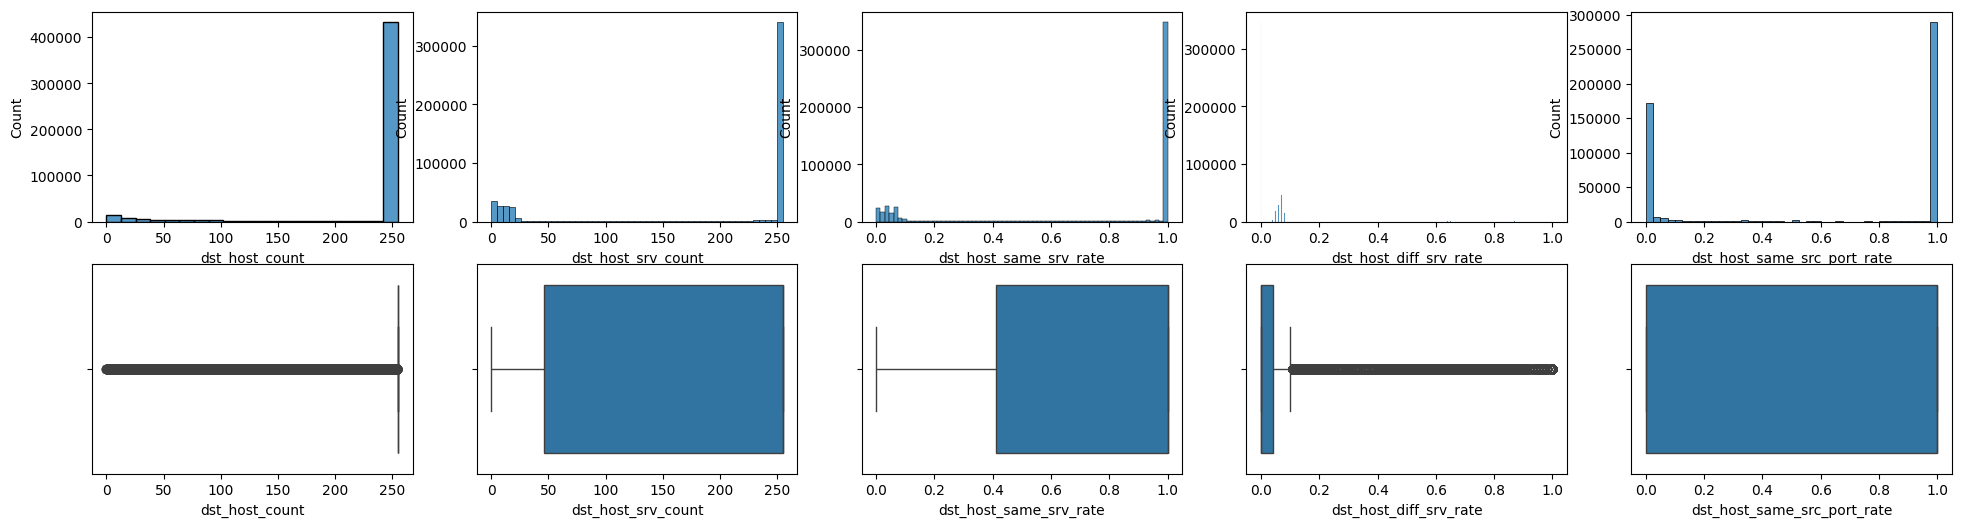

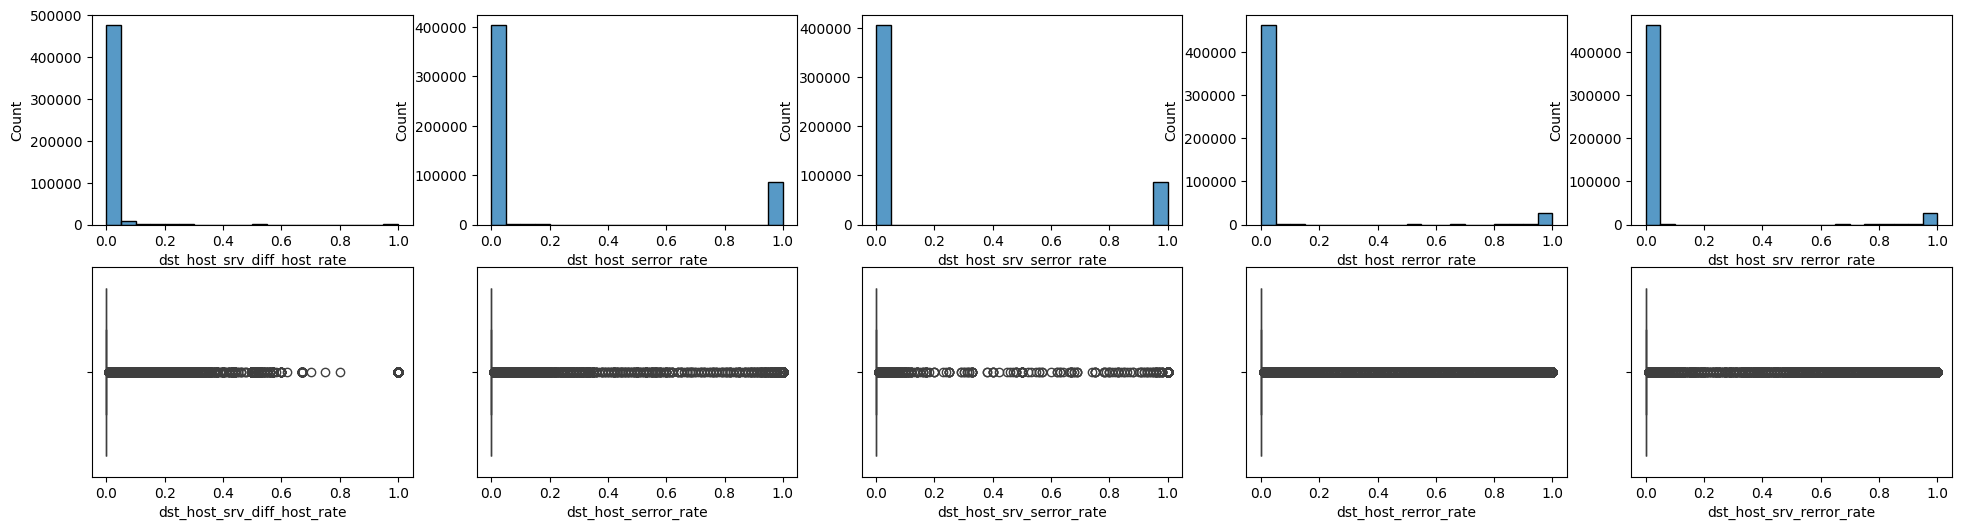

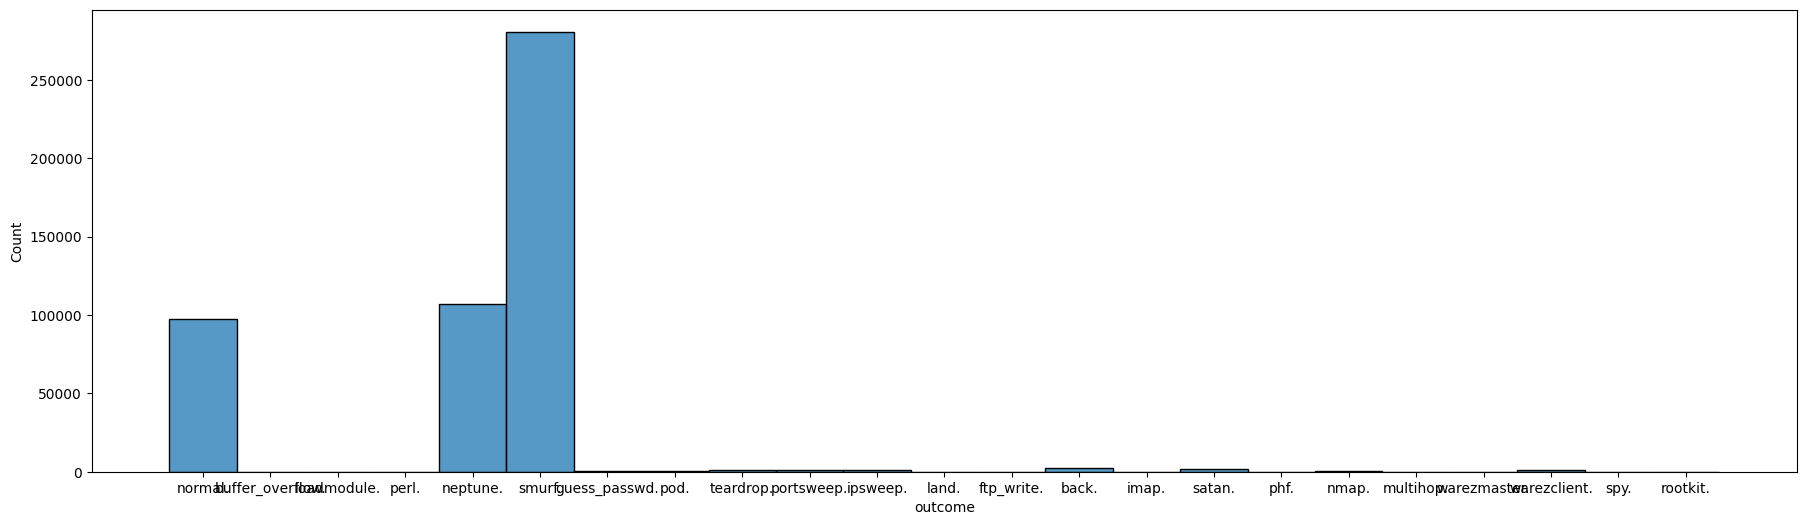

In [ ]:
# 4.2.1.2

print(df.describe())

plot_columns = 5
plot_rows = 8
plot_depth = 2
def printPlots(columns):
  fig, axes = plt.subplots(plot_depth, len(columns), figsize=(24, 6))
  for i in range(plot_depth):
    for j in range(len(columns)):
      if i == 0:
        sns.histplot(df, ax=axes[i][j], x=columns[j])
      elif i == 1:
        sns.boxplot(df, ax=axes[i][j], x=columns[j])
  plt.show()

for i in range(plot_rows):
  printPlots(columns[i*plot_columns:(i+1)*plot_columns])

plt.rcParams['figure.figsize'] = (22, 6)
sns.histplot(df['outcome'])
plt.show()

In [ ]:
print(df['num_outbound_cmds'].unique())
print(df['is_host_login'].unique())
df.drop(columns=['num_outbound_cmds', 'is_host_login'], inplace=True)

[0]
[0]


In [ ]:
# 4.2.1.3

print(df.isna().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_s

In [ ]:
# 4.2.1.4

num_columns = df.select_dtypes(include=np.number).columns.tolist()
mmsc = MinMaxScaler()
for column in num_columns:
  df[column] = mmsc.fit_transform(pd.DataFrame(df.loc[:,column]))

cat_columns = df.select_dtypes(include=object).columns.tolist()
cat_columns.remove('outcome')
df = pd.get_dummies(df, columns=cat_columns)
cat_columns = df.select_dtypes(include=bool).columns.tolist()
for column in cat_columns:
  df[column] = df[column].astype(int)

df_prep = df.copy()

In [ ]:
# 4.2.1.5

df_train, df_test = train_test_split(df_prep, test_size=0.2)

df_train_normal = df_prep[df_prep['outcome'] == 'normal.'].drop('outcome',
                                                                axis=1)
df_train_anom = df_prep[df_prep['outcome'] != 'normal.'].drop('outcome',
                                                              axis=1)

df_test_normal = df_test[df_test['outcome'] == 'normal.'].drop('outcome',
                                                               axis=1)
df_test_anom = df_test[df_test['outcome'] != 'normal.'].drop('outcome',
                                                             axis=1)

In [ ]:
# 4.2.1.6

# encoder
input = tf.keras.layers.Input(shape=(df_train_normal.shape[1],), name='Input')
enc1 = tf.keras.layers.Dense(128, activation='relu', name='Enc_1')(input)
enc2 = tf.keras.layers.Dense(32, activation='relu', name='Enc_2')(enc1)
enc3 = tf.keras.layers.Dense(8, activation='relu', name='Enc_3')(enc2)
encoder = tf.keras.Model(input, enc3, name="Encoder")
encoder.summary()

# decoder
dec1 = tf.keras.layers.Dense(32, activation='relu', name='Dec_2')(enc3)
dec2 = tf.keras.layers.Dense(128, activation='relu', name='Dec_3')(dec1)
output = tf.keras.layers.Dense(df_train_normal.shape[1],
                               activation='sigmoid', name='Output')(dec2)
decoder = tf.keras.Model(enc3, output, name='Decoder')
decoder.summary()

# autoencoder
autoencoder = tf.keras.Model(input, output, name='Autoencoder')
autoencoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 116)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Enc_1 (Dense)                   │ (None, 128)            │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Enc_2 (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Enc_3 (Dense)                   │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,368 (75.66 KB)

 Trainable params: 19,368 (75.66 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_8CLONE             │ (None, 8)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dec_2 (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dec_3 (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 116)            │        14,964 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,476 (76.08 KB)

 Trainable params: 19,476 (76.08 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 116)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Enc_1 (Dense)                   │ (None, 128)            │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Enc_2 (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Enc_3 (Dense)                   │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dec_2 (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dec_3 (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 116)            │        14,964 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,844 (151.73 KB)

 Trainable params: 38,844 (151.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4.2.1.7

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# 4.2.1.8

history = autoencoder.fit(df_train_normal, df_train_normal,
                          validation_data=(df_test_normal, df_test_normal),
                          epochs=50,
                          batch_size=256,
                          callbacks=[EarlyStopping(monitor='val_loss',
                                     patience=10,
                                     restore_best_weights=True)])

with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
autoencoder.save("my_autoencoder.keras")

Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1954 - val_loss: 0.0179
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0163 - val_loss: 0.0133
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0129 - val_loss: 0.0122
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 8/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 9/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 10/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 11/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 12/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/ste

In [ ]:
# autoencoder = load_model("my_autoencoder.keras")
# with open('/trainHistoryDict', "rb") as file_pi:
#     history = pickle.load(file_pi)

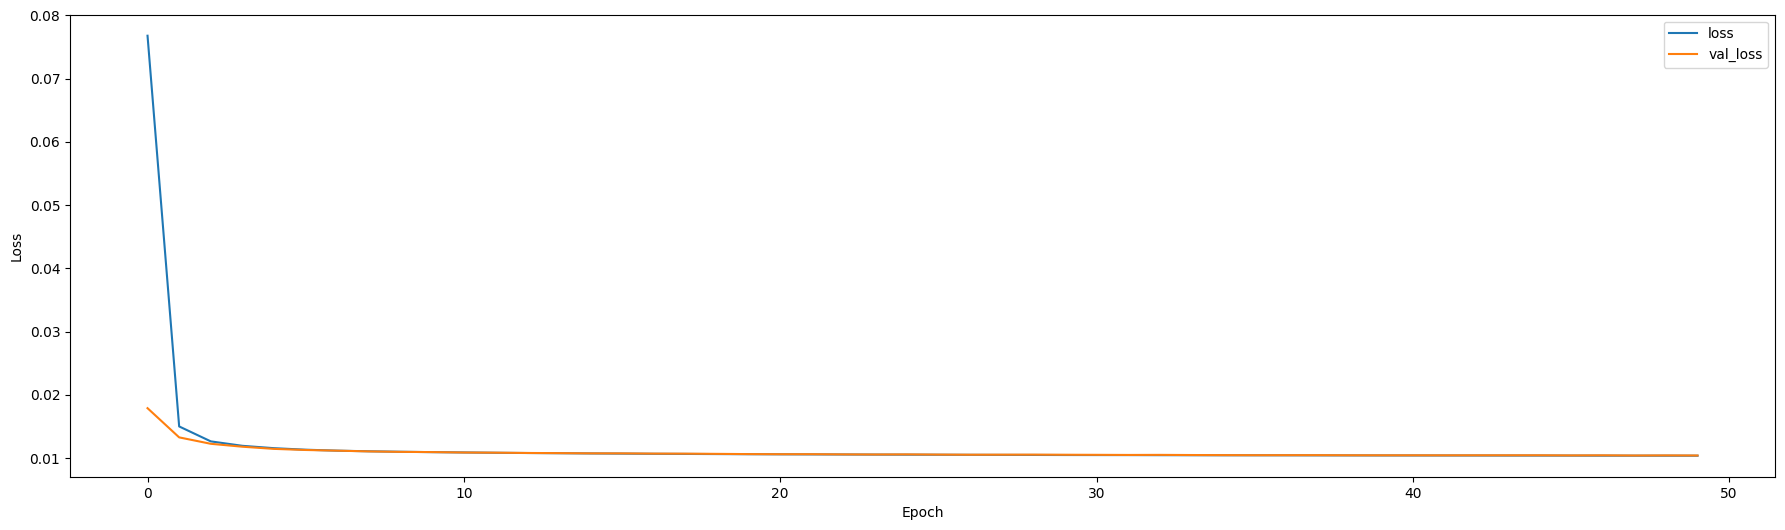

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'], '-', color='C0', label='loss')
ax1.plot(history.history['val_loss'], '-', color='C1', label='val_loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel('Loss')
plt.legend();

3040/3040 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
12399/12399 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
2479/2479 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


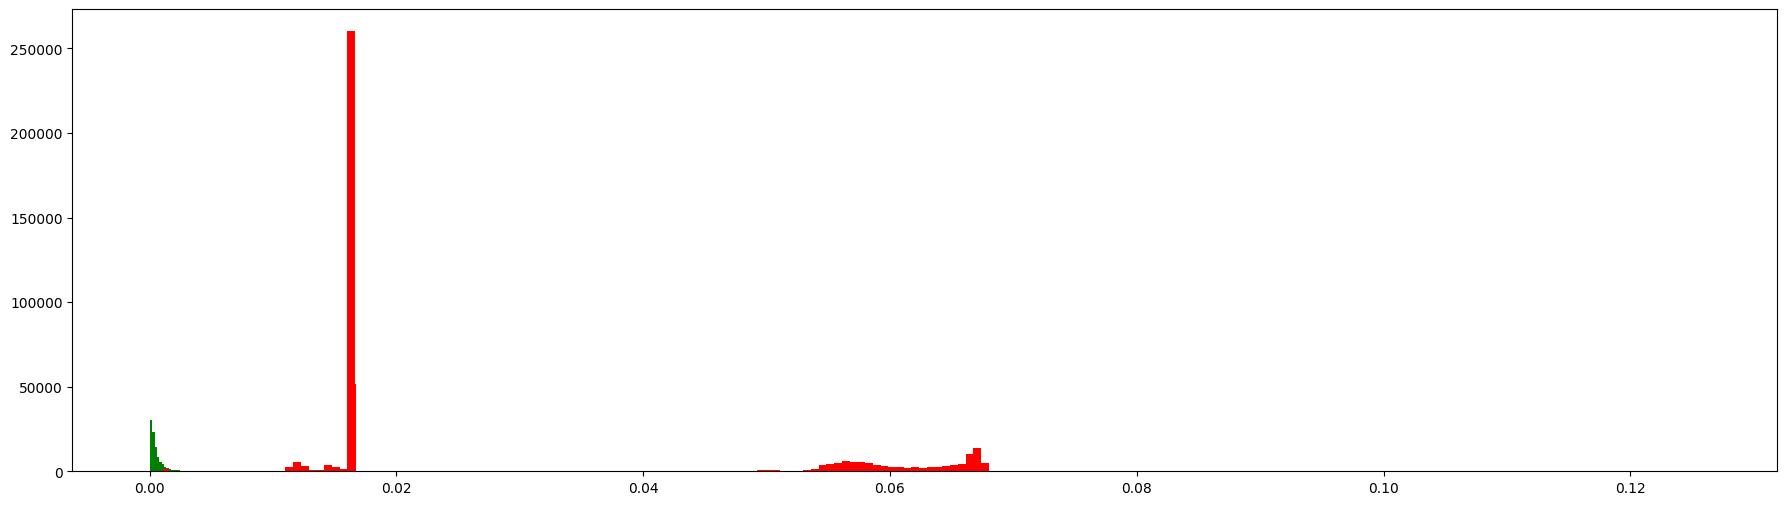

In [ ]:
# 4.2.1.9

df_train_normal_decoded = autoencoder.predict(df_train_normal)
df_test_normal_decoded = autoencoder.predict(df_test_normal)
df_train_anom_decoded = autoencoder.predict(df_train_anom)
df_test_anom_decoded = autoencoder.predict(df_test_anom)

train_normal_re = np.mean(np.abs(df_train_normal - df_train_normal_decoded), axis=1)
test_normal_re = np.mean(np.abs(df_test_normal - df_test_normal_decoded), axis=1)
train_anom_re = np.mean(np.abs(df_train_anom - df_train_anom_decoded), axis=1)
test_anom_re = np.mean(np.abs(df_test_anom - df_test_anom_decoded), axis=1)

plt.hist(train_normal_re, bins=200, color='g');
plt.hist(test_normal_re, bins=200, color='g');
plt.hist(train_anom_re, bins=200, color='r');
plt.hist(test_anom_re, bins=200, color='r');

Wizualizacja błędu rekonstrukcji w postaci histogramu wskazuje na to, że za wartość progu odcięcia separującą przypadki normalne od anomalnych można być threshold=0.01.

In [ ]:
y_true = np.where(df_test['outcome'] != 'normal.', 1, 0)
df_test.drop('outcome', axis=1, inplace=True)
df_test_pred = autoencoder.predict(df_test)
reconstruction_error = np.mean(np.abs(df_test - df_test_pred), axis=1)
threshold = 0.01
y_pred = (reconstruction_error > threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Confusion matrix:
[[19458    19]
 [  802 78525]]

Classification report:
              precision    recall  f1-score   support

           0     0.9604    0.9990    0.9793     19477
           1     0.9998    0.9899    0.9948     79327

    accuracy                         0.9917     98804
   macro avg     0.9801    0.9945    0.9871     98804
weighted avg     0.9920    0.9917    0.9918     98804



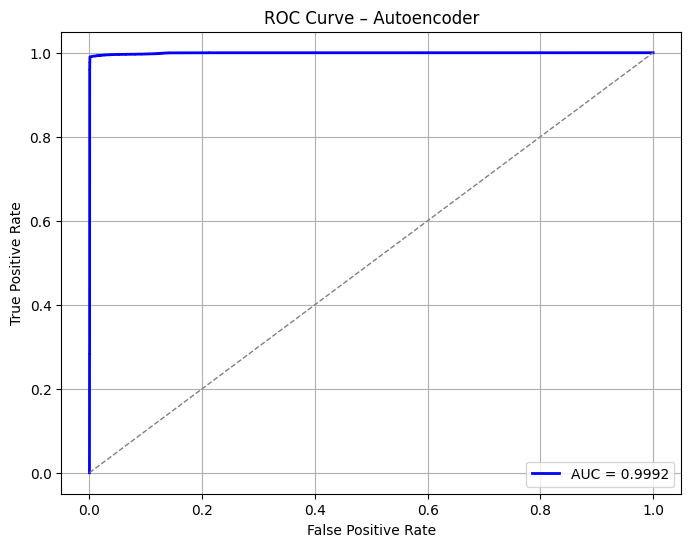

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, reconstruction_error)
roc_auc = roc_auc_score(y_true, reconstruction_error)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Autoencoder')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 4.2.1.9

- Otrzymana wartość metryki AUC= 0.9992 świadczy o tym że model bardzo dobrze radzi sobie z wykrywaniem anomalii w ruchu sieciowym
- W powyższym przypadku, aby odnależć optymalną wartość progu odcięcia wystarczyło odczytać ją z histogramu błędów rekonstrukcji. Oczywiście, poza tym sposobem istnieje również kilka innych, np. odczytanie z wykresu ROC, czy wyliczanie dla jakiej wartości progu odcięcia F1-score przyjmie największą wartość.
- Model nie wykazał tendencji do przetrenowywania się, wykresy i wartości opisując proces uczenia sieci wskazują że przebiegł on prawidłowo.
